In [9]:
import numpy as np
import pandas as pd
import pickle

import cv2

import matplotlib.pyplot as plt

import tensorflow as tf

In [13]:
path_to_train_pkl: str = './data/annotations/train.pkl'
path_to_train_img: str = './data/images/'

In [17]:
train_data: pd.DataFrame = pd.read_pickle(path_to_train_pkl)
train_data_before = train_data[:]
train_data['file_name'] = path_to_train_img + train_data['file_name']

In [15]:
tf.keras.layers.RandomCrop(height=255, width=255)

,file_name,id,species,breed,breed_onehot
1097,./data/images/newfoundland_101,23,2,16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2784,./data/images/keeshond_190,19,2,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2440,./data/images/english_cocker_spaniel_147,13,2,7,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1694,./data/images/Sphynx_158,34,1,12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2494,./data/images/english_setter_154,14,2,8,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
3059,./data/images/pomeranian_171,25,2,17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
957,./data/images/leonberger_110,20,2,14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1773,./data/images/wheaten_terrier_125,36,2,24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2141,./data/images/Bengal_188,6,1,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Train data without corrupt images

In [25]:
train_data_without_chi121 = train_data_before[train_data_before['file_name'] != 'chihuahua_121']

In [29]:
train_data_without_beagle116 = train_data_without_chi121[train_data_without_chi121['file_name'] != 'beagle_116']

In [31]:
train_data_without_beagle116.to_pickle(path_to_train_pkl)

# Images

In [4]:
def read_image_data_augmentation(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
    if tf.random.uniform(shape=[]) > 0.5:
        image = tf.image.flip_left_right(image)
    image = tf.image.resize_with_crop_or_pad(image, target_width=224, target_height=224)
    return image, label


def read_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
    image = tf.image.resize_with_crop_or_pad(image, target_width=224, target_height=224)
    return image, label

In [5]:
def load_dataset(path_to_images: str,
                 path_to_pkl: str,
                 model_type: str,
                 batch_size: int,
                 data_augmentation: bool = False) -> tf.data.Dataset:
    df = pd.read_pickle(path_to_pkl)
    df['file_name'] = path_to_images + df['file_name'] + '.jpg'

    x = df['file_name'].values
    if model_type == "Binary":
        y = df['species'].values - 1
    else:
        y = np.stack(df['id_onehot'].values)

    if data_augmentation:
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).map(read_image_data_augmentation).batch(batch_size=batch_size)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((x, y)).map(read_image).batch(batch_size=batch_size)
    return dataset

In [6]:
training_dataset: tf.data.Dataset = load_dataset(path_to_images='./data/images/',
                                                 path_to_pkl='./data/annotations/train.pkl',
                                                 model_type='Binary',
                                                 batch_size=8,
                                                 data_augmentation=True)

In [22]:
img, lab = next(iter(training_dataset))

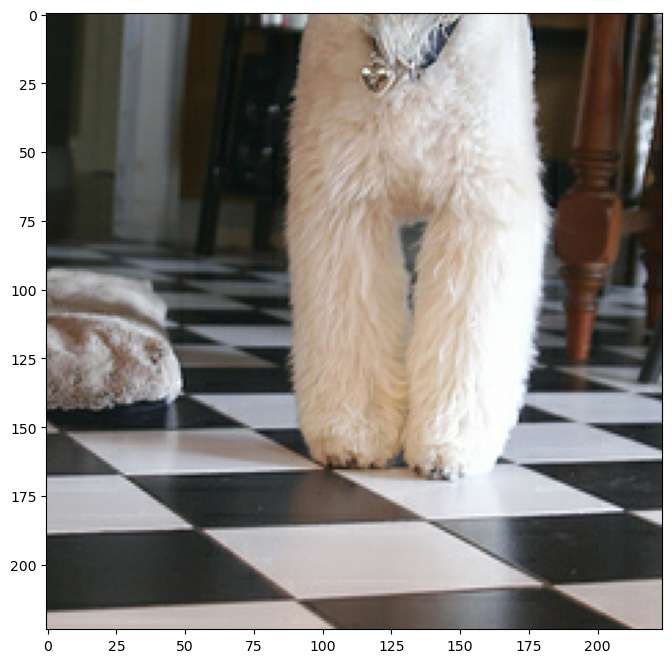

In [28]:
fig, axs = plt.subplots(figsize=(8, 8))
axs.imshow(img[1])
plt.show()

In [26]:
lab

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 0, 0, 0, 1, 0, 1], dtype=int64)>